# Analysis pipeline for concatenated recordings

Formozov, A., Chini, M. et al.
Calcium imaging and electrophysiology of hippocampal activity under anesthesia and natural sleep in mice (2021)

*** To save notebook as pdf without code: ***
https://stackoverflow.com/questions/34818723/export-notebook-to-pdf-without-code?noredirect=1&lq=1

In [34]:
import numpy as np

import numpy.ma as ma

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import os

sns.set()
sns.set_style("whitegrid")

from scipy.signal import medfilt 

from scipy.stats import skew, kurtosis, zscore

from scipy import signal

from sklearn.linear_model import LinearRegression, TheilSenRegressor

### Download and compile OASIS

In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  !wget https://raw.githubusercontent.com/mchini/Yang_Chini_et_al/testTransition/notebooks/capipeline.py
  !git clone https://github.com/j-friedrich/OASIS.git
  !pwd
  %cd /content/OASIS/
  !pwd
  import warnings
  warnings.filterwarnings("ignore")
  !python setup.py build_ext --inplace
  %cd ..
  !pwd
  from sys import path
  path.append(r'/content/OASIS')
else:
  print('Not running on CoLab')

Not running on CoLab


In [2]:
from capipeline import *

/media/andrey/My Passport/OASIS-master/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


# Upload and reprocess data or upload pre-processed data (see below)

### Upload data from GIN

At the rate 0.5 MB/s, it takes abouts 30 min (1.5 GB of data, one animal, one condition for transition state recordings)

In [35]:
# mimic path TS_C_ISO_8235 (transition state, concatenated, ISO, animal 8235)
full_path = "/data_colab/#8235_iso_minidataset/suite2p/plane0"
from pathlib import Path
path = Path('.' + full_path)
path.mkdir(parents=True, exist_ok=True)

### Download data (30 Mb)

In [36]:
# download data
%cd "./data_colab/#8235_iso_minidataset/suite2p/plane0"
download_path = "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/data_colab/%238235_iso_minidataset/suite2p/plane0/"
files = ["iscell.npy","F.npy","Fneu.npy"]
for f in files:
    link = download_path + f
    !wget $link
    
%cd "../../../.."

# download meta_data
!wget "https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/data_colab/meta_recordings_8235.xlsx"

/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/data_colab/concatenated_8235_iso
--2021-05-11 21:59:13--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/Anesthesia/calcium_imaging_transition_state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0/iscell.npy
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘iscell.npy’

iscell.npy              [ <=>                ]  38,08K  --.-KB/s    in 0,008s  

2021-05-11 21:59:14 (4,45 MB/s) - ‘iscell.npy’ saved [38992]

--2021-05-11 21:59:15--  https://gin.g-node.org/SW_lab/Anesthesia_CA1/raw/master/Anesthesia/calcium_imaging_transition_state/concatenated/8237/20201105_GCaMP6f_8237_MMF/suite2p/plane0/stat.npy
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.4

### Setup path and choose animals for the analysis

In [29]:
animals =['TS_C_ISO_8235']

database_path = 'meta_recordings_8235.xlsx'

rec = get_recordings_for_animals(animals, database_path)

print("Recordings for the analysis: " + str(rec) )

Recordings for the analysis: [9, 10, 11, 12, 13, 14, 15, 16, 17]


### Plot raster plot for the first three recordings 

Total trace length: 90044
Recording length: 13428
Analysis periods: [4000, 9000]
Analysis period total frames:  5000
Total trace length: 90044
Recording length: 18000
Analysis periods: [0, 5000]
Analysis period total frames:  5000
Total trace length: 90044
Recording length: 18000
Analysis periods: [0, 5000]
Analysis period total frames:  5000


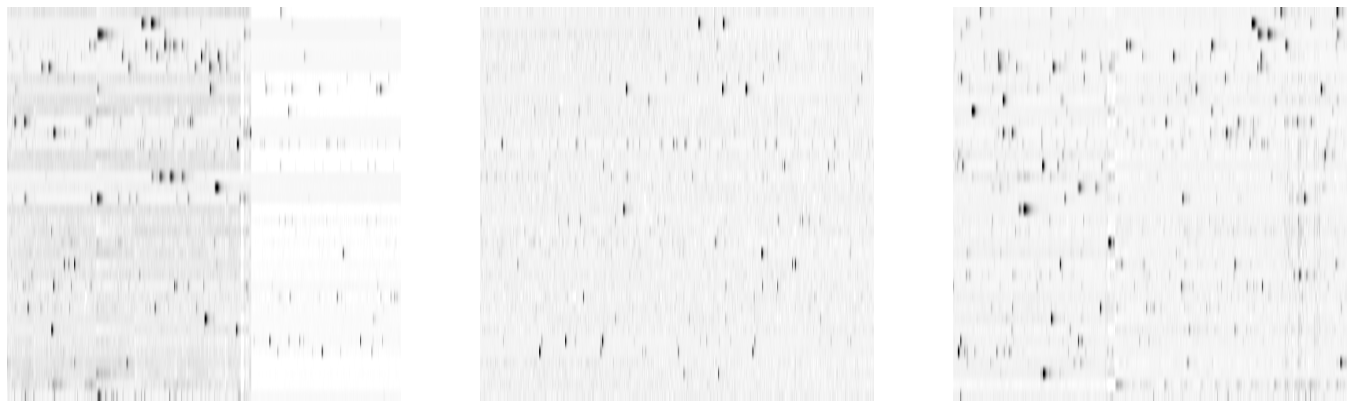

In [33]:
from capipeline import get_raster

nrec_to_plot = 3

starting_recording = rec[0]

fig, axes = plt.subplots(1, nrec_to_plot, figsize=(8*nrec_to_plot, 8), sharex=True)

for j in range(0,nrec_to_plot):
   
    raster = get_raster(starting_recording+j, 200, database_path, concatenation=True)
    
    axes[j].imshow(raster,extent=(0,7000,0,7000),cmap='Greys',vmin=0.25,vmax=1.0)
    
    axes[j].axis('off')

plt.show()

TS_C_MMF_M0 9 
Threshold for peak detection: 160
9 TS_C_MMF_M0 awake
Total trace length: 90044
Recording length: 13428
Analysis periods: [4000, 9000]
Analysis period total frames:  5000


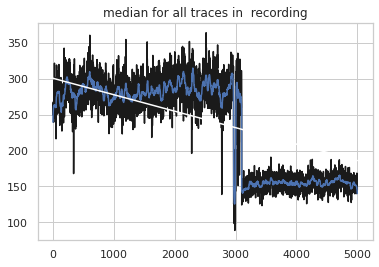

Median baseline: 240.39
Number of neurons accepted: 36
*****
TS_C_MMF_M0 10 
Threshold for peak detection: 160
10 TS_C_MMF_M0 mmf
Total trace length: 90044
Recording length: 18000
Analysis periods: [0, 5000]
Analysis period total frames:  5000


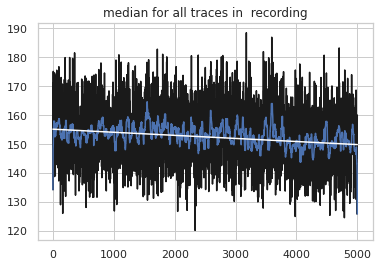

Median baseline: 137.65
Number of neurons accepted: 36
*****
TS_C_MMF_M0 11 
Threshold for peak detection: 160
11 TS_C_MMF_M0 post30
Total trace length: 90044
Recording length: 18000
Analysis periods: [0, 5000]
Analysis period total frames:  5000


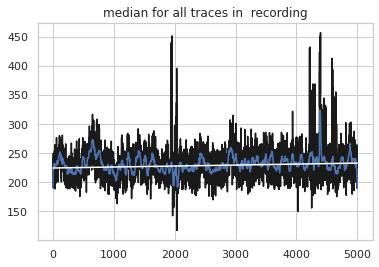

Median baseline: 171.61
Number of neurons accepted: 36
*****
TS_C_MMF_M0 12 
Threshold for peak detection: 160
12 TS_C_MMF_M0 post60
Total trace length: 90044
Recording length: 17432
Analysis periods: [0, 5000]
Analysis period total frames:  5000


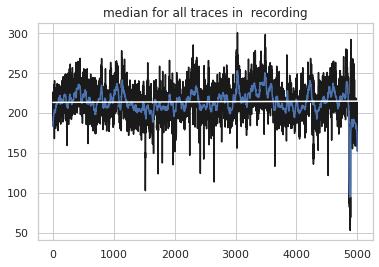

Median baseline: 175.93
Number of neurons accepted: 36
*****
TS_C_MMF_M0 13 
Threshold for peak detection: 160
13 TS_C_MMF_M0 post120
Total trace length: 90044
Recording length: 9210
Analysis periods: [0, 5000]
Analysis period total frames:  5000


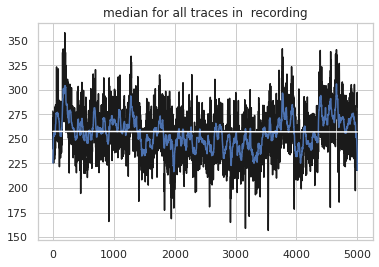

Median baseline: 216.73
Number of neurons accepted: 36
*****
TS_C_MMF_M0 14 
Threshold for peak detection: 160
14 TS_C_MMF_M0 post180
Total trace length: 90044
Recording length: 17005
Analysis periods: [8000, 13000]


IndexError: boolean index did not match indexed array along dimension 1; dimension is 13974 but corresponding boolean dimension is 17005

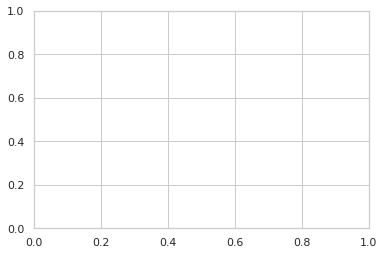

In [32]:
#### WHAT TO DO WITH EXCLUDED VALUES???

df_estimators = pd.DataFrame()

df_corrs =  pd.DataFrame()

for r in rec:
    
    animal = get_animal_from_recording(r, database_path)
    
    print(str(animal) + " " + str(r) + " ")

    if (animal=='TS_C_ISO_8235'): ### assign threshold
         threshold = 350  # for n-peaks detection
        
    print("Threshold for peak detection: " + str(threshold))
    df_e, df_c   = get_data_frame(r, database_path, threshold=threshold, baseline_correction=True,concatenation=True)

    df_estimators = pd.concat([df_estimators,df_e])
    df_corrs = pd.concat([df_corrs,df_c])

    print("********************************")
    print("********************************")

    
df_estimators['neuronID'] = df_estimators.index

### Store data frames

In [96]:
df_estimators.to_pickle("./df_estimators_TS_C_ISO_8235_n_peaks_baseline.pkl") 
df_corrs.to_pickle("./df_corrs_TS_C_ISO_8235_n_peaks_baseline.pkl") 

# Load reprocessed data

In [22]:
df_estimators = pd.read_pickle("./df_estimators_TS_C_ISO_8235_n_peaks_baseline.pkl")
df_corrs = pd.read_pickle("./df_corrs_TS_C_ISO_8235_n_peaks_baseline.pkl")

### Check availible conditions

In [21]:
np.unique(df_estimators.condition)

array(['awake', 'iso', 'rec120', 'rec180', 'rec240', 'rec30', 'rec300',
       'rec360', 'rec60'], dtype=object)

### Get statistics on the features and correlations 

**Main features (df_estimators):**

- n_peaks
- width.median
- height.median
- decay time
- skewness
- integral
- baseline
- number of active neurons

**Correlations (df_corrs):**

- Pearson correlation of neurons 
- absolute Pearson correlation of neurons

In [22]:
df_estimators.describe()

,recording,neuronID,n.accepted,length.frames,length.minutes,n.accepted_and_rejected,traces.median,npil.median,trace.std,npil.std,...,baseline.quantile.25,baseline.oasis,integral,peak_detection_threshold,decay_isol,decay_no_isol,n_peaks,n_peaks_per_recording,height.median,width.median
count,324.000000,324.000000,324.0,324.0,3.240000e+02,324.0,324.000000,324.000000,324.000000,324.000000,...,324.000000,324.000000,3.240000e+02,324.0,324.000000,324.000000,324.000000,324.000000,312.000000,312.000000
mean,4.000000,17.500000,36.0,5000.0,2.777778e+00,50.0,324.509369,111.800453,35.357086,35.357086,...,208.902290,151.694465,1.210021e+02,160.0,0.568825,0.468506,46.648889,129.580247,247.406149,32.329274
std,2.585983,10.404363,0.0,0.0,4.447761e-16,0.0,152.569412,50.096855,12.839503,12.839503,...,129.593332,123.251030,7.804143e+01,0.0,2.653464,0.269583,26.556344,73.767623,72.698977,80.339760
min,0.000000,0.000000,36.0,5000.0,2.777778e+00,50.0,35.381977,-16.534363,2.965278,2.965278,...,9.267549,0.000000,-4.394531e-07,160.0,0.011903,0.009351,0.000000,0.000000,161.619537,11.527806
25%,2.000000,8.750000,36.0,5000.0,2.777778e+00,50.0,203.472305,78.913557,28.244373,28.244373,...,107.235358,65.589056,8.460025e+01,160.0,0.225407,0.291170,30.600000,85.000000,208.607885,16.120041
50%,4.000000,17.500000,36.0,5000.0,2.777778e+00,50.0,298.253036,111.321335,33.939331,33.939331,...,185.939035,122.866362,1.196476e+02,160.0,0.315072,0.427557,47.520000,132.000000,230.617294,20.447222
75%,6.000000,26.250000,36.0,5000.0,2.777778e+00,50.0,428.525314,140.395012,42.803130,42.803130,...,280.580778,219.496521,1.537380e+02,160.0,0.419684,0.615636,64.890000,180.250000,263.720875,27.720145
max,8.000000,35.000000,36.0,5000.0,2.777778e+00,50.0,861.643555,383.212769,71.646561,71.646561,...,705.642059,693.072865,5.519805e+02,160.0,33.316664,1.384317,102.240000,284.000000,757.238220,1317.591239


In [23]:
df_corrs.describe()

,recording,Tm0p7Ncorr,Tm0p7Ncorr.abs
count,11664.0000,11340.000000,11340.000000
mean,4.0000,0.011858,0.047966
std,2.5821,0.076327,0.060543
min,0.0000,-0.372281,0.000011
25%,2.0000,-0.025265,0.012305
50%,4.0000,0.001326,0.028487
75%,6.0000,0.032968,0.059367
max,8.0000,0.768480,0.768480


### Get median value of the feature for a given animal

In [25]:
df_estimators[(df_estimators.animal=='TS_C_ISO_8235')].groupby('condition', as_index=False)['n_peaks'].median()

,condition,n_peaks
0,awake,45.90
1,iso,0.72
2,rec120,40.32
3,rec180,45.72
4,rec240,38.88
5,rec30,48.78
6,rec300,78.66
7,rec360,52.38
8,rec60,69.48


In [26]:
df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.999)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median()

,condition,Tm0p7Ncorr.abs
0,awake,0.033670
1,iso,0.012471
2,rec120,0.030973
3,rec180,0.045038
4,rec240,0.035366
5,rec30,0.028701
6,rec300,0.040380
7,rec360,0.024327
8,rec60,0.024774


### Violin plot for a given feature

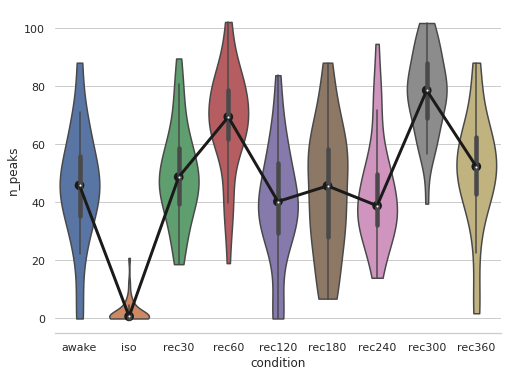

In [28]:
feature = 'n_peaks' # number of peaks per min
conditions = ["awake","iso","rec30","rec60","rec120","rec180","rec240","rec300","rec360"]

f, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.despine(left=True)
#axes.set_ylim([0, 100.0])
sns.violinplot(x='condition', y=feature, data=df_estimators,ax=axes,order = conditions,scale='width',cut=0)
sns.pointplot(x='condition', y=feature, markers='o', scale=1.1, color='k',data=df_estimators.groupby('condition', as_index=False)[feature].median(), ax=axes,order=conditions)
plt.savefig("n_peaks.png")
plt.savefig("n_peaks.eps")

### Violin plot for correlations

Text(0, 0.5, 'Absolute Pearson Correlation')

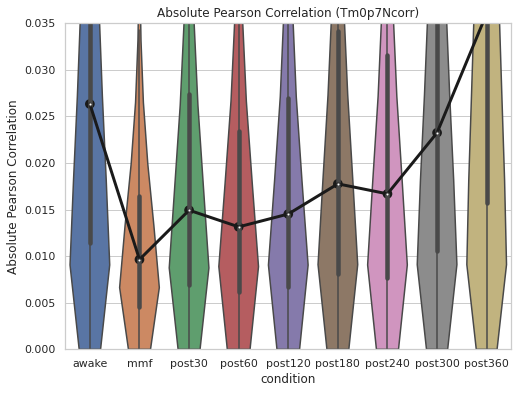

In [11]:
plt.rcParams['figure.figsize'] = [8, 6]

conditions = ["awake","iso","rec30","rec60","rec120","rec180","rec240","rec300","rec360"]

sns.violinplot(x='condition', y='Tm0p7Ncorr.abs',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)],order=conditions,scale='width',cut=0)
sns.pointplot(x='condition', y='Tm0p7Ncorr.abs', markers='o', scale=1.1, color='k',data=df_corrs[(df_corrs['Tm0p7Ncorr.abs'] < 0.9)].groupby('condition', as_index=False)['Tm0p7Ncorr.abs'].median(),order=conditions)

plt.ylim([-0.00,0.2])
#plt.yscale('log')
#plt.savefig("correlations.png")
#plt.savefig("correlations.eps")
plt.title("Absolute Pearson Correlation (Tm0p7Ncorr)")
plt.ylabel("Absolute Pearson Correlation")


# Single-neuron level analysis

List of availible features:

'animal', 'recording', 'condition', 'neuronID', 'n.accepted', 'length.frames',
'length.minutes', 'n.accepted_and_rejected', 'traces.median', 'npil.median', 
'trace.std', 'npil.std', 'trace.mins', 'trace.maxs', 'trace.peak_to_peak', 
'npil.mins', 'npil.maxs', 'npil.peak_to_peak', 'trace.skewness', 'npil.skewness',
'Tm0p7N.skewness', 'Tm0p7N.median', 'Tm0p7N.std', 'trace.kurtosis', 'npil.kurtosis',
'npil.slope', 'npil.intercept', 'npil.residual', 'npil.slope_per_median', 'npil.slope_in_percent',
'npil.mstab.1000', 'baseline.quantile.25', 'baseline.oasis', 'integral', 'peak_detection_threshold',
'decay_isol', 'decay_no_isol', 'n_peaks', 'n_peaks_per_recording', 'height.median', 'width.median'


In [26]:
df_estimators['neuronID'] = df_estimators.index # make a column from neuronID (to be removed from here and added to the reprocessing)

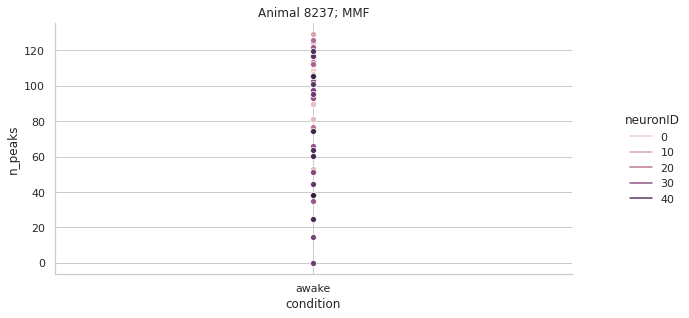

In [27]:
g=sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators[df_estimators.neuronID<50], marker='o',hue='neuronID',kind='line')
g.fig.set_size_inches(12,8)
plt.title("Animal 8235; MMF")
plt.savefig("single-neuron-level-analysis.png")
plt.savefig("single-neuron-level-analysis.eps")

### Conditioning (track neurons that active/non-active in awake condition)

In [ ]:
neuron_ID_awake_active = df_estimators[(df_estimators.condition == 'awake')&(df_estimators.n_peaks > 10)].neuronID
neuron_ID_awake_non_active = df_estimators[(df_estimators.condition == 'awake')&(df_estimators.n_peaks < 10)].neuronID

In [ ]:
df_estimators_non_active_in_awake = df_estimators.loc[df_estimators['neuronID'].isin(neuron_ID_awake_non_active)]
df_estimators_active_in_awake = df_estimators.loc[df_estimators['neuronID'].isin(neuron_ID_awake_active)]

In [ ]:
sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators_non_active_in_awake, marker='o',hue='neuronID',kind='line')
plt.title("Animal 8237; ISO (neurons non-active in awake condition, n_peaks < 10)")
sns.relplot(x = 'condition',y = 'n_peaks', data = df_estimators_active_in_awake, marker='o',hue='neuronID',kind='line')
plt.title("Animal 8237; ISO (neurons active in awake condition, n_peaks > 10)")

# Single-neuron level analysis (interactive)

### Number of transients, hight of transients and decay time constant in different conditions

In [2]:
import plotly.express as px

x_axis = "condition"
y_axis = "n_peaks"
marker_color = "height.median"
marker_size = 'decay_no_isol'

fig = px.scatter(df_estimators[df_estimators.neuronID<50], x=x_axis, y=y_axis, color=marker_color,
                 size=marker_size,width=1000, height=600)
#fig.write_image("n_peaks_scatter_interactive.eps")
#fig.write_image("n_peaks_scatter_interactive.png")
fig.show()

NameError: name 'df_estimators' is not defined

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df_estimators[df_estimators.neuronID<50], x="condition", y="decay_no_isol", z="height.median",
              color="condition", size="n_peaks", size_max=18,
              symbol="condition", opacity=0.7,hover_data=['neuronID','trace.std'])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))